In [1]:
!pip install apyori

In [2]:
#import libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
import random
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.metrics.pairwise import cosine_similarity
from apyori import apriori

## 1. Creation of a table of destinations and their attractions
The idea here is to create a list of cities and give them a random number of activities from a list of different categories. The distribution of number of activities per city will be lognormal, i. e., few cities will have a very low number and there will be fewer cities as this number increases, while most of them will be around the mode. The activities will be randomly put into one of the categories, with equal probabilities.

### 1.1 Creating the cities
The first idea was to name the cities as 'City_###', but I found a list of fictional locations from games, books, series and movies, so that will be more interesting. I'm using BeautifulSoup to read the website and extract the names of the cities.

In [3]:
#get list of fictional cities from website
url_cities = 'https://list.fandom.com/wiki/List_of_fictional_cities'
html_data=requests.get(url_cities).text
soup = BeautifulSoup(html_data,"html5lib") 

#getting the list from the HTML
list_cities=[]
html_text=soup.findAll('li')[81:-51]
for row in html_text:
    list_cities.append(row.text)

list_cities = [x.split(' - ')[0].split(',')[0].split(';')[0].split('(')[0] for x in list_cities]
#removing empty entries
list_cities = list(filter(None, list_cities))

#editing special cases (typos from the website)
list_special = ['Emmerdale from the British TV series of the same name','Capitol City the capital of the United States of America featured in the game Destroy All Humans! which is based on Washington DC.',
                "Walton's Mountain fictional site in the Blue Ridge Mountains for The Waltons","El-Ysa: village in Klatch in Terry Pratchett's Discworld. The inhabitants were killed when their well was poisoned ",
               "Kamurocho- A fictional city in the Yakuza series", "Everville -town on the West Coast of the USA in Clive Barker's Everville",
               "Earth City in Inverted World by Christopher Priest","Chronopolis by J. G. Ballard", "Villette of Charlotte Brontë", 
               "Ramgarh- Typical village in central India in early 70's. Venue for Bollywood blockbuster Sholay.","Tashbaan capital of the fictional land of Calormen in the Chronicles of Narnia",
               "Empire Bay- Fictional city inspired by New York in Mafia II","Omelas — utopian city from the short story The Ones Who Walk Away From Omelas by Ursula K. Le Guin",
               "St. Erasmus and St. Elmo's- fictional island in the South Caribbean", "The City of Dreadful Night by James Thomson",
               "Isidora from Le città invisibili by Italo Calvino.","PYRUS- capital city of Genovia from the movie the princess diaries",
               "Math a fictional state in an unpublished book 'Math Genius'","DenCity or DenTechCity", "Ephebe -somewhat Grecian city on the Circle Sea in Terry Pratchett's Discworld. Ruled by the "]
list_replace = ['Emmerdale','Capitol City',"Walton's Mountain",'El-Ysa','Kamurocho','Everville','Earth City','Chronopolis', 'Villette','Ramgarh','Tashbaan',"Empire Bay","Omelas",
               "St. Erasmus and St. Elmo's","The City of Dreadful Night","Isidora","Pyrus", "Math",'DenCity','Ephebe']

set1 = set(list_cities)
set2 = set(list_special)
list_cities = list(set1 - set2)
list_cities = list_cities+list_replace


print('Number of cities:',len(list_cities))
list_cities[0:10]


Number of cities: 987


['Darnley',
 'Hunger City',
 'Hercule City',
 'Masada',
 'Grimeworth',
 'Santo Bugito',
 'Doglick',
 'Aquadelphi',
 'Silver Town',
 'Strangehaven']

### 1.2 Creating the categories
Looking at websites that sell travel packages, we see lots of categories that are too similar. So here we defined ten different classes that represent most of the options. We are doing this so that each activity is only tagged by one of the categories.

In [4]:
categories = ['Food','Parks','Museums','Hiking','Beach','Romantic','History','Music','Theater','Sports']

### 1.3 Adding the activites to the cities
For each city from our list, we will randomly pick a number of activities, each one assigned to one of the categories above.

In [5]:
cities_activities = []
check_num_act = []
for city in list_cities:
    temp = [city]
    num_act = int(np.ceil(np.random.lognormal(2., 1.)))
    if num_act > 50:
        num_act = 50
    check_num_act.append(num_act)
    for ii in range(num_act):
        temp.append(categories[random.randint(0,9)]) 
    cities_activities.append(temp)
cities_activities[0]

['Darnley',
 'Sports',
 'Romantic',
 'Theater',
 'Parks',
 'Sports',
 'Romantic',
 'Music']

We can check if our distribution meets our expectation by plotting the histogram of the number of cities with a certain number of activities.

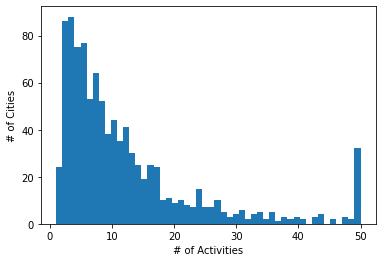

In [6]:
plt.hist(check_num_act,bins=50)
plt.xlabel('# of Activities')
plt.ylabel('# of Cities')
plt.show()

Let's turn this list of cities and activities into a dataframe and then export the file for later use.

In [7]:
columns_df = ['City']
for ii in range(50):
    if len(str(ii+1))<2:
        temp = 'Activity0'+str(ii+1)
    else:
        temp = 'Activity'+str(ii+1)
    columns_df.append(temp)
print(columns_df)

['City', 'Activity01', 'Activity02', 'Activity03', 'Activity04', 'Activity05', 'Activity06', 'Activity07', 'Activity08', 'Activity09', 'Activity10', 'Activity11', 'Activity12', 'Activity13', 'Activity14', 'Activity15', 'Activity16', 'Activity17', 'Activity18', 'Activity19', 'Activity20', 'Activity21', 'Activity22', 'Activity23', 'Activity24', 'Activity25', 'Activity26', 'Activity27', 'Activity28', 'Activity29', 'Activity30', 'Activity31', 'Activity32', 'Activity33', 'Activity34', 'Activity35', 'Activity36', 'Activity37', 'Activity38', 'Activity39', 'Activity40', 'Activity41', 'Activity42', 'Activity43', 'Activity44', 'Activity45', 'Activity46', 'Activity47', 'Activity48', 'Activity49', 'Activity50']


In [8]:
city_table = pd.DataFrame(cities_activities,columns=columns_df)
city_table.head()

,City,Activity01,Activity02,Activity03,Activity04,Activity05,Activity06,Activity07,Activity08,Activity09,...,Activity41,Activity42,Activity43,Activity44,Activity45,Activity46,Activity47,Activity48,Activity49,Activity50
0,Darnley,Sports,Romantic,Theater,Parks,Sports,Romantic,Music,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Hunger City,Romantic,History,Parks,Romantic,Romantic,Theater,Beach,Food,None,...,None,None,None,None,None,None,None,None,None,None
2,Hercule City,Music,Music,Theater,Music,Museums,Theater,Food,History,History,...,None,None,None,None,None,None,None,None,None,None
3,Masada,Museums,Hiking,Sports,Beach,Theater,Museums,History,Music,Beach,...,None,None,None,None,None,None,None,None,None,None
4,Grimeworth,Beach,History,Theater,Sports,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [9]:
city_table.tail(10)

,City,Activity01,Activity02,Activity03,Activity04,Activity05,Activity06,Activity07,Activity08,Activity09,...,Activity41,Activity42,Activity43,Activity44,Activity45,Activity46,Activity47,Activity48,Activity49,Activity50
977,Tashbaan,Sports,Sports,Romantic,Parks,Beach,Theater,Beach,Food,Food,...,None,None,None,None,None,None,None,None,None,None
978,Empire Bay,Romantic,Beach,Music,History,Music,Museums,None,None,None,...,None,None,None,None,None,None,None,None,None,None
979,Omelas,Parks,Music,Beach,Romantic,Romantic,Beach,Beach,Museums,Food,...,None,None,None,None,None,None,None,None,None,None
980,St. Erasmus and St. Elmo's,Food,Parks,Parks,Museums,Theater,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
981,The City of Dreadful Night,Parks,Sports,Food,Hiking,History,Museums,History,Theater,None,...,None,None,None,None,None,None,None,None,None,None
982,Isidora,Parks,Museums,Romantic,Sports,Theater,Hiking,Romantic,Sports,Sports,...,None,None,None,None,None,None,None,None,None,None
983,Pyrus,Food,Museums,Beach,Museums,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
984,Math,Museums,Hiking,Parks,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
985,DenCity,Beach,Theater,Theater,Beach,Food,History,None,None,None,...,None,None,None,None,None,None,None,None,None,None
986,Ephebe,History,Hiking,Music,Music,Romantic,Sports,Music,None,None,...,None,None,None,None,None,None,None,None,None,None


In [10]:
city_table.to_csv('city_table.csv',sep=';',index=False)

## 2. Creation of users and their history
The idea here is to create a large number of users by choosing a set of cities and activities they previously visited. For each customer, we will randomly pick a number of cities they already visited and select some of the local available activities.

### 2.1 Creating the users
The first idea was to name the users as 'User_#####', but I found a list with the distribution of given names in Brazil, so that will be more interesting. I'm importing the table and will focus only on the names, not the distribution.

In [11]:
with open('ibgenomes.csv', 'r') as read_obj: # read csv file as a list of lists
  csv_reader = csv.reader(read_obj) # pass the file object to reader() to get the reader object
  list_users_ibge = list(csv_reader) # Pass reader object to list() to get a list of lists

list_users = []
for row in list_users_ibge[1:]:
    list_users = list_users + [row[0]]

list_users[:10]

['MARIA',
 'JOSE',
 'ANA',
 'JOAO',
 'ANTONIO',
 'FRANCISCO',
 'CARLOS',
 'PAULO',
 'PEDRO',
 'LUCAS']

### 2.2 Selecting cities and activities
Now we will create a list with user, city, activity and category. We again use a lognormal distribution to choose the number of cities visited by each user. We randomly select this number of cities. For each city, we count the number of activities available and randomly select how many the user has done, selecting which ones also randomly. 

In [12]:
user_history = []

for name in list_users:
    num_cities = int(np.ceil(np.random.lognormal(.001, 1.)))
    if num_cities>len(city_table):
        num_cities=len(city_table)
    
    city_picks = random.sample(range(len(city_table)),num_cities)    
    for city in city_picks:
        num_act_city = 50-city_table.iloc[city,1:].isnull().sum()
        num_act = random.randint(1,num_act_city)
        act_picks = random.sample(range(num_act_city),num_act)
        for act in act_picks:
            user_history.append([name,city_table.iloc[city,0],columns_df[act+1],city_table.iloc[city,act+1]])

print(len(user_history))
user_history[100000:200000:5000]

909664


[['VALTENCIR', 'Camelot', 'Activity37', 'Romantic'],
 ['AILDO', "D'ni", 'Activity14', 'Music'],
 ['ANDREILSON', 'Lowerton', 'Activity08', 'Food'],
 ['VALDINES', 'Dhagabad', 'Activity15', 'Hiking'],
 ['NEURIVAN', 'Altomare', 'Activity11', 'Theater'],
 ['UENDERSON', 'Westopolis', 'Activity08', 'Theater'],
 ['IRENILDES', 'Christminster ', 'Activity07', 'Food'],
 ['FRANCIELTON', 'San Andreas', 'Activity09', 'History'],
 ['SELIANE', 'Dis', 'Activity31', 'Food'],
 ['SEVERA', 'Middlesex', 'Activity03', 'Parks'],
 ['ALESSANDA', 'The Tower of Fate', 'Activity06', 'Museums'],
 ['IZAU', 'Aquadelphi', 'Activity33', 'History'],
 ['LUCINEY', 'Lanford', 'Activity01', 'Parks'],
 ['EDINAIDE', 'Yian', 'Activity02', 'Theater'],
 ['RIBERTO', 'Rubacava', 'Activity11', 'Parks'],
 ['LOYANE', "King's Landing", 'Activity01', 'Food'],
 ['JAIRAN', 'Kor', 'Activity14', 'Food'],
 ['VANCLEI', 'Osgiliath', 'Activity10', 'Sports'],
 ['EVELAINE', 'Post-Apocalyptic New York City', 'Activity12', 'Romantic'],
 ['NELISE',

Let's turn this list of users and activities into a dataframe and then export the file for later use.


In [13]:
columns_users = ['Name','City','Activity','Category']
user_table = pd.DataFrame(user_history,columns=columns_users)
user_table.head()

,Name,City,Activity,Category
0,MARIA,Chronopolis,Activity05,Theater
1,MARIA,Chronopolis,Activity04,Music
2,MARIA,Chronopolis,Activity03,Food
3,MARIA,Chronopolis,Activity08,Theater
4,MARIA,Chronopolis,Activity02,Beach


In [14]:
user_table.to_csv('user_table.csv',sep=';',index=False)

## 3. Comparing cities
From our table with the activities for each city, we will create a new table where each row represents a city and each column shows the proportion of its activities for each category. For a city with a single 'Hiking' activity, its row will have *1* in the 'Hiking' column. If a city has three activities ('Museums', 'Romantic', Ḿuseums'), it will have *0.67* in the 'Museums' column and *0.33* in the 'Romantic' one. <br>
With this, we will have a vector describing each city and we can measure the similarities between two cities by the cosine similarity between their rows.

In [15]:
city_vector = city_table.apply(pd.Series.value_counts, axis=1)[categories].fillna(0)
city_vector = city_vector.div(city_vector.sum(axis=1), axis=0)
city_vector.insert(0, 'City', city_table['City'])
city_vector.head()

,City,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
0,Darnley,0.000,0.142857,0.000,0.00000,0.00000,0.285714,0.000,0.142857,0.142857,0.285714
1,Hunger City,0.125,0.125000,0.000,0.00000,0.12500,0.375000,0.125,0.000000,0.125000,0.000000
2,Hercule City,0.080,0.120000,0.080,0.08000,0.00000,0.040000,0.160,0.160000,0.160000,0.120000
3,Masada,0.000,0.125000,0.125,0.09375,0.21875,0.062500,0.125,0.125000,0.093750,0.031250
4,Grimeworth,0.000,0.000000,0.000,0.00000,0.25000,0.000000,0.250,0.000000,0.250000,0.250000


In [16]:
for ii in range(5):
    city_picks = random.sample(range(len(city_vector)),2)
    display(city_vector[city_vector.index.isin(city_picks)])
    print('Cosine similarity between ',city_vector.iloc[city_picks[0],0],'and ',city_vector.iloc[city_picks[1],0],'is ',float(cosine_similarity([city_vector.iloc[city_picks[0],1:]],[city_vector.iloc[city_picks[1],1:]])))

,City,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
365,Bad Ass,0.166667,0.000000,0.000000,0.333333,0.166667,0.000000,0.0,0.166667,0.166667,0.000000
834,Royston Vasey,0.133333,0.066667,0.066667,0.066667,0.266667,0.066667,0.2,0.066667,0.000000,0.066667


Cosine similarity between  Bad Ass and  Royston Vasey is  0.5378528742004771


,City,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
384,Liptákov,0.000000,0.090909,0.272727,0.363636,0.090909,0.000000,0.000000,0.181818,0.000000,0.000000
744,West Springfield,0.058824,0.000000,0.058824,0.117647,0.117647,0.117647,0.117647,0.117647,0.176471,0.117647


Cosine similarity between  Liptákov and  West Springfield is  0.5161002296110788


,City,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
125,Valkanvania,0.0,0.0,0.0,0.25,0.250000,0.500000,0.0,0.0,0.0,0.000000
177,Smallville,0.0,0.0,0.0,0.00,0.333333,0.333333,0.0,0.0,0.0,0.333333


Cosine similarity between  Smallville and  Valkanvania is  0.7071067811865476


,City,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
346,Reefside,0.00,0.0,0.125,0.125,0.00,0.25,0.00,0.125,0.125,0.25
628,Kocourkov,0.12,0.1,0.140,0.080,0.08,0.14,0.08,0.080,0.100,0.08


Cosine similarity between  Reefside and  Kocourkov is  0.7462025072446367


,City,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
374,Stilwater,0.142857,0.0,0.0,0.142857,0.0,0.0,0.142857,0.428571,0.0,0.142857
494,Baldur's Gate,0.500000,0.0,0.0,0.000000,0.0,0.5,0.000000,0.000000,0.0,0.000000


Cosine similarity between  Stilwater and  Baldur's Gate is  0.19611613513818402


What we want is to find the cities with the highest cosine similarity to our target. So let's try to find the cities most similar to our first city.

In [17]:
corr_df = pd.DataFrame(columns=['City','Similarity'])
for ii in range(len(city_vector)):
    temp=[city_vector.iloc[ii,0]]
    temp.append(float(cosine_similarity([city_vector.iloc[0,1:]],[city_vector.iloc[ii,1:]])))
    corr_df.loc[len(corr_df)] = temp
corr_df = corr_df.sort_values(by='Similarity',ascending=False)
corr_df[corr_df['Similarity']>0.75]

,City,Similarity
0,Darnley,1.000000
185,Midland City,0.921132
955,Erinsborough,0.906103
312,Frenchmen Bay,0.870388
346,Reefside,0.870388
162,Aleero City,0.858116
126,Grovers Bend,0.853610
214,Liberty,0.852803
815,Yankerville,0.852803
623,Houstone,0.844232


We now have the list of the cities most similar to *Quirm*. We can confirm this by displaying the vectors of those cities.

In [18]:
city_picks = corr_df[corr_df['Similarity']>0.75].index
display(city_vector[city_vector.index.isin(city_picks)])

,City,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
0,Darnley,0.000000,0.142857,0.000000,0.000000,0.000000,0.285714,0.000000,0.142857,0.142857,0.285714
8,Silver Town,0.166667,0.166667,0.083333,0.000000,0.000000,0.250000,0.083333,0.083333,0.083333,0.083333
11,Hensonville,0.200000,0.200000,0.000000,0.000000,0.000000,0.200000,0.000000,0.200000,0.000000,0.200000
21,Nabooru,0.000000,0.090909,0.090909,0.000000,0.090909,0.090909,0.090909,0.000000,0.181818,0.363636
66,Gebra ?,0.083333,0.083333,0.111111,0.055556,0.083333,0.222222,0.111111,0.083333,0.000000,0.166667
78,Arnette,0.102564,0.102564,0.076923,0.025641,0.076923,0.153846,0.128205,0.153846,0.051282,0.128205
82,Viron,0.000000,0.000000,0.142857,0.000000,0.000000,0.428571,0.142857,0.000000,0.000000,0.285714
101,Llanview,0.000000,0.125000,0.000000,0.187500,0.062500,0.125000,0.125000,0.125000,0.062500,0.187500
126,Grovers Bend,0.136364,0.045455,0.045455,0.090909,0.045455,0.181818,0.045455,0.090909,0.090909,0.227273
141,Bedrock,0.058824,0.117647,0.117647,0.058824,0.058824,0.176471,0.000000,0.117647,0.176471,0.117647


## 4. Comparing users
From our table with the activities for each user, we will create a new table where each row represents a user and each column shows the proportion of its activities for each category. For a user with a single 'Hiking' activity, its row will have *1* in the 'Hiking' column. If a user has three activities ('Museums', 'Romantic', Ḿuseums'), it will have *0.67* in the 'Museums' column and *0.33* in the 'Romantic' one. We will group the activities from all visited cities.<br>
With this, we will have a vector describing each user and we can measure the similarities between two users by the correlation between their rows.

In [ ]:
list_names = user_table['Name'].unique().tolist()
user_act = []
for name in list_names:
    user_act.append(user_table[user_table['Name']==name]['Category'].tolist())
columns_user_df = []
for ii in range(len(max(user_act, key=len))):
    if len(str(ii))<2:
        temp = 'Activity000'+str(ii)
    elif len(str(ii))<3:
        temp = 'Activity00'+str(ii)
    elif len(str(ii))<4:
        temp = 'Activity0'+str(ii)
    else:
        temp = 'Activity'+str(ii+1)
    columns_user_df.append(temp)
user_act_table = pd.DataFrame(user_act,columns=columns_user_df)
user_vector = user_act_table.apply(pd.Series.value_counts, axis=1)[categories].fillna(0)
user_vector = user_vector.div(user_vector.sum(axis=1), axis=0)
user_vector.insert(0, 'Name', list_names)
user_vector.head()

In [ ]:
for ii in range(5):
    user_picks = random.sample(range(len(user_vector)),2)
    display(user_vector[user_vector.index.isin(user_picks)])
    print('Cosine similarity between ',user_vector.iloc[user_picks[0],0],'and ',user_vector.iloc[user_picks[1],0],'is ',float(cosine_similarity([user_vector.iloc[user_picks[0],1:]],[user_vector.iloc[user_picks[1],1:]])))

What we want is to find the users with the highest cosine similarity to our target. So let's try to find the users most similar to our first user.

In [ ]:
corr_user_df = pd.DataFrame(columns=['Name','Similarity'])
for ii in range(len(user_vector)):
    temp=[user_vector.iloc[ii,0]]
    temp.append(float(cosine_similarity([user_vector.iloc[0,1:]],[user_vector.iloc[ii,1:]])))
    corr_user_df.loc[len(corr_user_df)] = temp
corr_user_df = corr_user_df.sort_values(by='Similarity',ascending=False)
corr_user_df[corr_user_df['Similarity']>0.9]

We now have the list of the users most similar to our first user. We can confirm this by displaying the vectors of those users.

In [ ]:
user_picks = corr_user_df[corr_user_df['Similarity']>0.9].index
display(user_vector[user_vector.index.isin(user_picks)])

## 5. Comparing users and cities
We now have vectors representing each city and user, with their ratio of categories. We can find the cities that best match a user and vice versa. 

### 5.1 Finding cities matching an user
We will give an example by finding cities that are similar to the behavior of our first user.

In [ ]:
corr_user_cities_df = pd.DataFrame(columns=['City','Similarity'])
for ii in range(len(city_vector)):
    temp=[city_vector.iloc[ii,0]]
    temp.append(float(cosine_similarity([user_vector.iloc[0,1:]],[city_vector.iloc[ii,1:]])))
    corr_user_cities_df.loc[len(corr_user_cities_df)] = temp
corr_user_cities_df = corr_user_cities_df.sort_values(by='Similarity',ascending=False)
corr_user_cities_df[corr_user_cities_df['Similarity']>0.75]

In [ ]:
display(user_vector[user_vector.index==0])
user_cities_picks = corr_user_cities_df[corr_user_cities_df['Similarity']>0.75].index
display(city_vector[city_vector.index.isin(user_cities_picks)])

### 5.2 Finding users matching a city
We will give an example by finding users that are similar to the behavior of our first city.

In [ ]:
corr_city_users_df = pd.DataFrame(columns=['Name','Similarity'])
for ii in range(len(user_vector)):
    temp=[user_vector.iloc[ii,0]]
    temp.append(float(cosine_similarity([city_vector.iloc[0,1:]],[user_vector.iloc[ii,1:]])))
    corr_city_users_df.loc[len(corr_city_users_df)] = temp
corr_city_users_df = corr_city_users_df.sort_values(by='Similarity',ascending=False)
corr_city_users_df[corr_city_users_df['Similarity']>0.9]

In [ ]:
display(city_vector[city_vector.index==0])
city_users_picks = corr_city_users_df[corr_city_users_df['Similarity']>0.9].index
display(user_vector[user_vector.index.isin(city_users_picks)])

## 6 City Suggestions
For a selected user, we want to make recommendations of cities that match their history and try to rank them. 

### 6.1 Cosine Similarity
The first option is finding cities by similarity with the user vector (done in section 5.1). Another option is to find the users that have the highest cosine similarity (section 4) and find the city that is most common among them.

Let's build upon we have done in section 4 and try to find the cities visited by those users.

In [ ]:
corr_user_df[corr_user_df['Similarity']>0.9]

We want to create a list of cities visited by these users and how many times each one was visited. We will remove any cities that were already visited by our target.

In [ ]:
list_corr_names = corr_user_df[corr_user_df['Similarity']>0.9]['Name'].tolist()
target_index = 0
user_table_filtered = user_table[user_table['Name'].isin(list_corr_names)]
list_corr_cities = []
list_target = user_table_filtered[user_table_filtered['Name']==user_vector.iloc[target_index,0]]['City'].unique().tolist()
for name in list_corr_names:
    if user_vector[user_vector['Name']==name].index != target_index:
        temp = user_table_filtered[user_table_filtered['Name']==name]['City'].unique().tolist()
        list_corr_cities += list(set(temp)-set(list_target))

count_corr_cities = {i:list_corr_cities.count(i) for i in list_corr_cities}
max_value = max(count_corr_cities.values()) 
if max_value > 1:
    sugg_cities = [k for k, v in count_corr_cities.items() if v == max_value]
    
else:
    sugg_cities = count_corr_cities.keys

print('List of cities:', sugg_cities,'with', max_value,'occurence(s).')   


Let's check the cosine similarity of these cities with our target user.

In [ ]:
corr_user_cities_test_df = pd.DataFrame(columns=['City','Similarity'])
city_vector_filtered = city_vector[city_vector['City'].isin(sugg_cities)]
for ii in range(len(city_vector_filtered)):
    temp=[city_vector_filtered.iloc[ii,0]]
    temp.append(float(cosine_similarity([user_vector.iloc[0,1:]],[city_vector_filtered.iloc[ii,1:]])))
    corr_user_cities_test_df.loc[len(corr_user_cities_test_df)] = temp
corr_user_cities_test_df = corr_user_cities_test_df.sort_values(by='Similarity',ascending=False)
corr_user_cities_test_df

Let's compare with cities that matched our user.

In [ ]:
corr_user_cities_df[corr_user_cities_df['Similarity']>0.75]

### 6.2 Association Rule Learning - *A Priori*

For this approach, we will try to extract knowledge from the user database. Let's try to create rules of association of the kind "*People who visited the city A should also visit city B.*" We are going to use the library **apyori**, but we need to work on our user data.

Our input data needs to be a list where each component is the list of cities visited by the users.

In [ ]:
list_cities_visited = []
for user in user_vector['Name'].tolist():
    list_cities_visited.append(user_table[user_table['Name']==user]['City'].unique().tolist())

list_cities_visited[:10]

In [ ]:
rules = apriori(transactions=list_cities_visited, min_support=1e-10, min_confidence=1e-10, min_lift=1.00001, min_length=2, max_length=2)

In [ ]:
results = list(rules)
def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs,rhs,supports,confidences,lifts))
results_df = pd.DataFrame(inspect(results), columns=['City1', 'City2', 'Support', 'Confidence','Lift'])

In [ ]:
display(len(results_df))
results_df.head()

Let's check what cities are suggested by the algorithm for the first city, sorted by how strong this reccomendation is.

In [ ]:
results_df[results_df['City1']==city_vector.iloc[0,0]].sort_values(by='Lift',ascending=False).head(5)

This output extracts the relation between two cities based on the user data. We don't have data covering all possible pairs of cities, just under 20%.

### 6.3 Final Approach
What we expect from our algorithm is to get five new cities that an user should consider visiting based on his/her history and the data from all users.<br>
For that specific user, we retrieve the list of cities visited and filter the results of our association rule learning. We sort them by *Lift* and present the five cities with the highest score, checking for repeated results. <br>
We might have special cases where we don't have five cities in our results. To complete our list, we will go back to our simpler correlation system, with the cities with largest correlation to the user that are not already on the list.

## 7 Activities recommendation
For each of the cities on our suggestion list, we will use the association rule learning to show us five activites that best match our user's past experiences.<br>
Let's try to create rules of association of the kind "People who visited the atraction X in city A should also visit atraction Y in city B." Again, we need to work on our user data.

In [ ]:
list_act_visited = []
user_table['City-Act'] = user_table['City'] + ' - ' + user_table['Activity']
for user in user_vector['Name'].tolist():
    list_act_visited.append(user_table[user_table['Name']==user]['City-Act'].tolist())

list_act_visited[:10]

In [ ]:
rules_act = apriori(transactions=list_act_visited, min_support=1e-10, min_confidence=1e-10, min_lift=1.00001, min_length=2, max_length=2)
results_act = list(rules_act)
results_act_df = pd.DataFrame(inspect(results_act), columns=['Activity1', 'Activity2', 'Support', 'Confidence','Lift'])

In [ ]:
display(len(results_act_df))
results_act_df.head()

In [ ]:
results_act_df[results_act_df['Activity1']==user_table.iloc[0,1]+' - '+user_table.iloc[0,2]].sort_values(by='Lift',ascending=False).head()

For the activities, we won't complete the list if there are less than five.

In [ ]:
results_act_df.sort_values(by='Lift',ascending=False).tail()

In [ ]:
len(list_act_visited)